In [394]:
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
%matplotlib inline

## Load data


In [293]:
def load_data(): # import SMEB
    fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/05.cockpit/cockpit_file_agg_naintrap_event.csv'
    data_smeb = pd.read_csv(fname, index_col=0)
    # select columns to keep 
    tt = [c for c in data_smeb.columns.tolist() if 'event_Price_SMEB_total_sanswater' in c]
    print(tt)
    cols = ['q_sbd', 'q_gov','q_district','month', 'event_Price_SMEB_total_sanswater_median_up_10']
    data_smeb = data_smeb[cols]
    # data_smeb.head()

    # import displacement
    fname = '/Users/hkromer/01_Projects/15.Hack4Good2019/02.Data/01.IMPACT_Data/movement_monitoring/04.feature_eng.displacement.csv'
    data_IDP = pd.read_csv(fname, index_col=0)
    # select columns to keep 
    cols = ['q_sbd', 'q_gov', 'q_district','month', 'inc_min_IDPs_sum',
     'inc_max_IDPs_sum',
     'inc_min_pre_conf_pop_remained_mean',
     'inc_max_pre_conf_pop_remained_mean',
     'delta_rel_min_IDPs_sum',
     'delta_rel_max_IDPs_sum',
     'delta_abs_min_pre_conf_pop_remained_mean',
     'delta_abs_max_pre_conf_pop_remained_mean']
    data_IDP = data_IDP[cols]
    # data_IDP.head()

    # join the data based on the smeb data
    data = data_smeb.merge(data_IDP, left_on=['q_sbd','month','q_gov','q_district'], right_on = ['q_sbd','month','q_gov','q_district'], how='left')
    assert data.shape[0] == data_smeb.shape[0]
    return data

## Split train test

In [271]:
data = data.dropna().reset_index(drop=True)
data

q_sbd q_gov q_district  month  \
0    SY020001  SY02     SY0200      7   
1    SY020001  SY02     SY0200     10   
2    SY020001  SY02     SY0200     11   
3    SY020001  SY02     SY0200     12   
4    SY020001  SY02     SY0200     13   
..        ...   ...        ...    ...   
306  SY110302  SY11     SY1103     16   
307  SY110302  SY11     SY1103     17   
308  SY110302  SY11     SY1103     18   
309  SY110302  SY11     SY1103     19   
310  SY110302  SY11     SY1103     22   

     event_Price_SMEB_total_sanswater_median_up_10 inc_min_IDPs_sum  \
0                                              0.0             True   
1                                              0.0            False   
2                                              0.0            False   
3                                              0.0             True   
4                                              0.0            False   
..                                             ...              ...   
306                                            0.0            False   
307                                            1.0            False   
308                                            1.0            False   
309                                            1.0            False   
310                                            0.0            False   

    inc_max_IDPs_sum inc_min_pre_conf_pop_remained_mean  \
0               True                              False   
1              False                              False   
2              False                              False   
3              False                              False   
4              False                              False   
..               ...                                ...   
306            False                              False   
307            False                              False   
308            False                              False   
309            False                              False   
310            False                              False   

    inc_max_pre_conf_pop_remained_mean  delta_rel_min_IDPs_sum  \
0                                False                0.009079   
1                                False               -0.008483   
2                                False               -0.027742   
3                                False                0.002533   
4                                False               -0.010640   
..                                 ...                     ...   
306                              False               -0.454545   
307                              False                0.000000   
308                              False                0.000000   
309                              False               -0.100000   
310                              False               -0.074074   

     delta_rel_max_IDPs_sum  delta_abs_min_pre_conf_pop_remained_mean  \
0                  0.005044                                  0.000000   
1                 -0.009285                                  0.000000   
2                 -0.032232                                 -3.571429   
3                 -0.001374                                -28.571429   
4                 -0.006094                                  0.000000   
..                      ...                                       ...   
306               -0.428571                                  0.000000   
307                0.000000                                  0.000000   
308                0.000000                                  0.000000   
309               -0.125000                                  0.000000   
310                0.000000                                  0.000000   

     delta_abs_max_pre_conf_pop_remained_mean  
0                                    0.000000  
1                                    0.000000  
2                                   -3.571429  
3                                  -28.571429  
4                                    0.0000

In [272]:
x_cols = ['q_sbd','inc_max_IDPs_sum','inc_max_pre_conf_pop_remained_mean','delta_rel_max_IDPs_sum','delta_abs_max_pre_conf_pop_remained_mean']
X = data[x_cols]
le = preprocessing.LabelEncoder()

X.loc[:,'inc_max_IDPs_sum'] = le.fit_transform(X.loc[:,'inc_max_IDPs_sum'])
X.loc[:,'inc_max_pre_conf_pop_remained_mean'] = le.fit_transform(X.loc[:,'inc_max_pre_conf_pop_remained_mean'])
X.loc[:,'q_sbd'] = le.fit_transform(X.loc[:,'q_sbd'])

y = data['event_Price_SMEB_total_sanswater_median_up_10']

# le = preprocessing.LabelEncoder()
# y = le.fit_transform(y)
# a = pd.Series(y)
# a.value_counts()

/Users/hkromer/anaconda3/envs/h4g/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision tree

In [274]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, y_pred)

(0.9395161290322581, 0.746031746031746)

In [275]:
feat_imp = dict(zip(X_train.columns, clf.feature_importances_))
df_feat_imp = pd.DataFrame(feat_imp, index=['Feature_importance']).T.sort_values(by='Feature_importance', ascending=False)
df_feat_imp

Feature_importance
delta_rel_max_IDPs_sum                              0.574824
q_sbd                                               0.340894
delta_abs_max_pre_conf_pop_remained_mean            0.065320
inc_max_pre_conf_pop_remained_mean                  0.016720
inc_max_IDPs_sum                                    0.002242

## GradientBoostingClassifier

In [276]:
clf = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, y_pred)

(0.8064516129032258, 0.8095238095238095)

In [277]:
feat_imp = dict(zip(X_train.columns, clf.feature_importances_))
df_feat_imp = pd.DataFrame(feat_imp, index=['Feature_importance']).T.sort_values(by='Feature_importance', ascending=False)
df_feat_imp

Feature_importance
delta_rel_max_IDPs_sum                              0.513149
q_sbd                                               0.373660
delta_abs_max_pre_conf_pop_remained_mean            0.104092
inc_max_IDPs_sum                                    0.008111
inc_max_pre_conf_pop_remained_mean                  0.000988

## Stratified split

/Users/hkromer/anaconda3/envs/h4g/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Split 1
Split 2
Split 3
Split 4
Split 5
Split 6
Split 7
Split 8
Split 9
Split 10
Split 11
Split 12
Split 13
Split 14
Split 15
Split 16
Split 17
Split 18
Split 19
Split 20
Split 21
Split 22
Split 23
Split 24
Split 25
Split 26
Split 27
Split 28
Split 29
Split 30
Split 31
Split 32
Split 33
Split 34
Split 35
Split 36
Split 37
Split 38
Split 39
Split 40
Split 41
Split 42
Split 43
Split 44
Split 45
Split 46
Split 47
Split 48
Split 49
Split 50


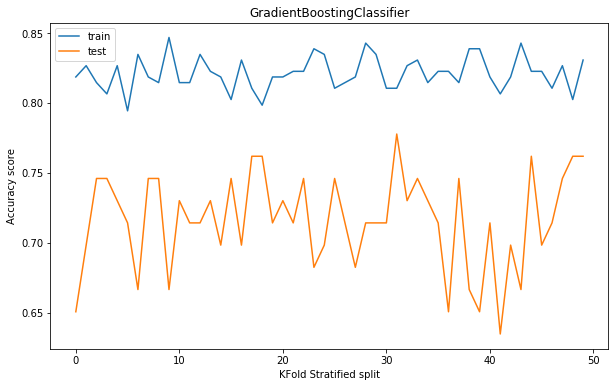

array([0.3742533 , 0.00156582, 0.0015686 , 0.51863002, 0.10398226])

In [278]:
x_cols = ['q_sbd','inc_max_IDPs_sum','inc_max_pre_conf_pop_remained_mean','delta_rel_max_IDPs_sum','delta_abs_max_pre_conf_pop_remained_mean']
X = data[x_cols]
le = preprocessing.LabelEncoder()

X.loc[:,'inc_max_IDPs_sum'] = le.fit_transform(X.loc[:,'inc_max_IDPs_sum'])
X.loc[:,'inc_max_pre_conf_pop_remained_mean'] = le.fit_transform(X.loc[:,'inc_max_pre_conf_pop_remained_mean'])
X.loc[:,'q_sbd'] = le.fit_transform(X.loc[:,'q_sbd'])

y = data['event_Price_SMEB_total_sanswater_median_up_10']
sss = StratifiedShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
# sss.get_n_splits(X, y)
X = X.values
y = y.values

cnt = 1
train_acc = []
test_acc = []
for train_index, test_index in sss.split(X, y):
    print(f"Split {cnt}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=10)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    train_acc.append(accuracy_score(y_train, clf.predict(X_train)))
    test_acc.append(accuracy_score(y_test, y_pred))
    cnt+=1
    
plt.figure(figsize=(10,6))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('GradientBoostingClassifier')
plt.ylabel('Accuracy score')
plt.xlabel('KFold Stratified split')
plt.legend()
plt.show()
clf.feature_importances_

## Split train test split by months

Take the first 8 months for train, use remaining 4 for test

In [364]:
data = load_data()
data = data.dropna().reset_index()

['event_Price_SMEB_total_sanswater_up_10', 'event_Price_SMEB_total_sanswater_down_10', 'event_Price_SMEB_total_sanswater_median_up_10', 'event_Price_SMEB_total_sanswater_median_down_10']


In [365]:
data.month.value_counts().sort_index()

7     18
10    23
11    20
12    14
13    20
14    20
15    23
16    37
17    37
18    38
19    35
22    26
Name: month, dtype: int64

In [366]:
data_train = data[(data['month']<=16)]
data_test = data[(data['month']>16)]

data_train.shape, data_test.shape

((175, 14), (136, 14))

In [367]:
data_train

index     q_sbd q_gov q_district  month  \
0        6  SY020001  SY02     SY0200      7   
1        9  SY020001  SY02     SY0200     10   
2       10  SY020001  SY02     SY0200     11   
3       11  SY020001  SY02     SY0200     12   
4       12  SY020001  SY02     SY0200     13   
..     ...       ...   ...        ...    ...   
302   1815  SY110302  SY11     SY1103     12   
303   1816  SY110302  SY11     SY1103     13   
304   1817  SY110302  SY11     SY1103     14   
305   1818  SY110302  SY11     SY1103     15   
306   1819  SY110302  SY11     SY1103     16   

     event_Price_SMEB_total_sanswater_median_up_10 inc_min_IDPs_sum  \
0                                              0.0             True   
1                                              0.0            False   
2                                              0.0            False   
3                                              0.0             True   
4                                              0.0            False   
..                                             ...              ...   
302                                            0.0            False   
303                                            0.0            False   
304                                            0.0            False   
305                                            0.0            False   
306                                            0.0            False   

    inc_max_IDPs_sum inc_min_pre_conf_pop_remained_mean  \
0               True                              False   
1              False                              False   
2              False                              False   
3              False                              False   
4              False                              False   
..               ...                                ...   
302            False                              False   
303            False                              False   
304            False                              False   
305            False                              False   
306            False                              False   

    inc_max_pre_conf_pop_remained_mean  delta_rel_min_IDPs_sum  \
0                                False                0.009079   
1                                False               -0.008483   
2                                False               -0.027742   
3                                False                0.002533   
4                                False               -0.010640   
..                                 ...                     ...   
302                              False               -0.037037   
303                              False                0.000000   
304                              False               -0.153846   
305                              False                0.000000   
306                              False               -0.454545   

     delta_rel_max_IDPs_sum  delta_abs_min_pre_conf_pop_remained_mean  \
0                  0.005044                                  0.000000   
1                 -0.009285                                  0.000000   
2                 -0.032232                                 -3.571429   
3                 -0.001374                                -28.571429   
4                 -0.006094                                  0.000000   
..                      ...                                       ...   
302                0.000000                                  0.000000   
303                0.000000                                  0.000000   
304               -0.125000                                  0.000000   
305                0.000000                                  0.000000   
306               -0.428571                                  0.000000   

     delta_abs_max_pre_conf_pop_remained_mean  
0                                    0.000000  
1                                    0.000000  
2                                   -3.571429  
3   

In [387]:
x_cols = ['q_sbd','inc_max_IDPs_sum','inc_max_pre_conf_pop_remained_mean','delta_rel_max_IDPs_sum','delta_abs_max_pre_conf_pop_remained_mean']

# training data
X_train = data_train[x_cols]
y_train = data_train['event_Price_SMEB_total_sanswater_median_up_10']

# test data
X_test = data_test[x_cols]
y_test = data_test['event_Price_SMEB_total_sanswater_median_up_10']

# 0 or 1
for col in ['inc_max_IDPs_sum', 'inc_max_pre_conf_pop_remained_mean']:
    X_train[col] = pd.to_numeric(X_train[col]).astype(int)
    X_test[col] = pd.to_numeric(X_test[col]).astype(int)

# categorical data 
# train
dum_sbd = pd.get_dummies(X_train['q_sbd'])
dum_sbd.columns = ['sbd_' + str(col) for col in dum_sbd.columns]
X_train = X_train.merge(dum_sbd, left_index=True, right_index=True)
X_train = X_train.drop(columns='q_sbd')
# test
dum_sbd = pd.get_dummies(X_test['q_sbd'])
dum_sbd.columns = ['sbd_' + str(col) for col in dum_sbd.columns]
X_test = X_test.merge(dum_sbd, left_index=True, right_index=True)
X_test = X_test.drop(columns='q_sbd')
test_cols = [c for c in X_test.columns if 'sbd' in c]
train_cols = [c for c in X_train.columns if 'sbd' in c]


for c in train_cols:
    if c not in test_cols:
        X_train = X_train.drop(columns=c)
        print(f'{c} is not in test_cols')
for c in test_cols:
    if c not in train_cols:
        X_test = X_test.drop(columns=c)
        print(f'{c} is not in train_cols')


sbd_SY020304 is not in train_cols
sbd_SY080302 is not in train_cols


/Users/hkromer/anaconda3/envs/h4g/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/hkromer/anaconda3/envs/h4g/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [395]:
rfc = RandomForestClassifier(random_state = 42)
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

/Users/hkromer/anaconda3/envs/h4g/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 100}

In [399]:
clf = RandomForestClassifier(criterion = 'gini',
 max_depth = 4,
 max_features='auto',
 n_estimators=100,
 random_state= 42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# always predict 0
y_0 = np.zeros(len(y_test))
print(f'Accuracy score always predict 0 in test set: {accuracy_score(y_test, y_0)}')
# always predict 1
y_1 = np.ones(len(y_test))
print(f'Accuracy score always predict 1 in test set: {accuracy_score(y_test, y_1)}')

accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, y_pred)

Accuracy score always predict 0 in test set: 0.6838235294117647
Accuracy score always predict 1 in test set: 0.3161764705882353


(0.8514285714285714, 0.6838235294117647)

In [402]:
y_test.value_counts()

0.0    93
1.0    43
Name: event_Price_SMEB_total_sanswater_median_up_10, dtype: int64

In [ ]:
from sklearn.linear_model import LogisticRegression


In [391]:
feat_imp = dict(zip(X_train.columns, clf.feature_importances_))
df_feat_imp = pd.DataFrame(feat_imp, index=['Feature_importance']).T.sort_values(by='Feature_importance', ascending=False)
df_feat_imp

Feature_importance
delta_rel_max_IDPs_sum                              0.312897
delta_abs_max_pre_conf_pop_remained_mean            0.113292
sbd_SY080200                                        0.080327
sbd_SY090106                                        0.064972
sbd_SY020004                                        0.050026
inc_max_IDPs_sum                                    0.041143
sbd_SY070501                                        0.037471
sbd_SY110300                                        0.034233
sbd_SY020306                                        0.033049
sbd_SY020801                                        0.031733
inc_max_pre_conf_pop_remained_mean                  0.026823
sbd_SY020600                                        0.025080
sbd_SY110202                                        0.021770
sbd_SY070200                                        0.019187
sbd_SY110102                                        0.014905
sbd_SY020001                                        0.013867
sbd_SY110100                                        0.013320
sbd_SY050202                                        0.011729
sbd_SY070005                                        0.009766
sbd_SY020400                                        0.008045
sbd_SY110200                                        0.005373
sbd_SY070305                                        0.003436
sbd_SY070004                                        0.003323
sbd_SY050204                                        0.003262
sbd_SY070002                                        0.003261
sbd_SY110302                                        0.003062
sbd_SY070402                                        0.002940
sbd_SY070203                                        0.001311
sbd_SY070301                                        0.001186
sbd_SY110301                                        0.001101
sbd_SY110201                                        0.000839
sbd_SY020405                                        0.000818
sbd_SY070201                                        0.000800
sbd_SY070403                                        0.000737
sbd_SY090101                                        0.000655
sbd_SY070303                                        0.000626
sbd_SY070003                                        0.000620
sbd_SY020305                                        0.000580
sbd_SY090102                                        0.000518
sbd_SY070500                                        0.000489
sbd_SY020203                                        0.000457
sbd_SY070304                                        0.000382
sbd_SY020800                                        0.000317
sbd_SY050101                                        0.000149
sbd_SY020200                                        0.000124

In [308]:
x_cols = ['q_sbd','inc_max_IDPs_sum','inc_max_pre_conf_pop_remained_mean','delta_rel_max_IDPs_sum','delta_abs_max_pre_conf_pop_remained_mean']

# training data
X_train = data_train[x_cols]
y_train = data_train['event_Price_SMEB_total_sanswater_median_up_10']

# test data
X_test = data_test[x_cols]
y_test = data_test['event_Price_SMEB_total_sanswater_median_up_10']

# numeric data 
numeric_features = ['delta_rel_max_IDPs_sum', 'delta_abs_max_pre_conf_pop_remained_mean']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['q_sbd', 'inc_max_IDPs_sum', 'inc_max_pre_conf_pop_remained_mean']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# prediction pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(n_estimators = 1000, random_state = 42))])


clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# always predict 0
y_0 = np.zeros(len(y_test))
print(f'Accuracy score always predict 0 in test set: {accuracy_score(y_test, y_0)}')
# always predict 1
y_1 = np.ones(len(y_test))
print(f'Accuracy score always predict 1 in test set: {accuracy_score(y_test, y_1)}')

accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, y_pred)

Accuracy score always predict 0 in test set: 0.6838235294117647
Accuracy score always predict 1 in test set: 0.3161764705882353


(0.9885714285714285, 0.6102941176470589)

In [309]:
feat_imp = dict(zip(X_train.columns, clf.named_steps['classifier'].feature_importances_))
df_feat_imp = pd.DataFrame(feat_imp, index=['Feature_importance']).T.sort_values(by='Feature_importance', ascending=False)
df_feat_imp

Feature_importance
q_sbd                                               0.305099
inc_max_IDPs_sum                                    0.101249
delta_rel_max_IDPs_sum                              0.050052
inc_max_pre_conf_pop_remained_mean                  0.014248
delta_abs_max_pre_conf_pop_remained_mean            0.000191

In [320]:
clf.named_steps['classifier'].feature_importances_, clf.named_steps['classifier'].get_params()

(array([3.05099307e-01, 1.01249481e-01, 1.42479772e-02, 5.00520320e-02,
        1.91421818e-04, 4.39398779e-04, 5.83540824e-04, 3.30394810e-02,
        7.61263670e-03, 9.85668487e-04, 2.52648816e-02, 2.53544452e-04,
        3.10904726e-02, 1.35721600e-04, 1.22022053e-02, 3.76110435e-03,
        3.64940599e-03, 6.13502760e-04, 3.14582057e-03, 1.03713415e-02,
        2.06328984e-02, 8.53055733e-04, 1.36027896e-03, 1.19223393e-03,
        8.03279326e-04, 4.98166955e-04, 3.53731260e-03, 3.30995197e-03,
        7.70042150e-04, 5.89777768e-04, 3.90198772e-02, 7.97811371e-02,
        9.02047599e-04, 7.03366453e-04, 6.35459140e-02, 1.53890780e-02,
        1.51823952e-02, 5.76088411e-03, 8.27709423e-04, 2.23045374e-02,
        3.51172708e-02, 1.11839851e-03, 3.44855480e-03, 2.41625617e-02,
        2.21160252e-02, 1.67026691e-02, 1.63816308e-02]),
 {'bootstrap': True,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': 'auto',
  'max_leaf_nodes': None,
  'min_im

In [336]:
clf.named_steps['preprocessor']

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True))],
                                          verbose=False),
                                 ['delta_rel_max_IDPs_sum',
                                  'delta_abs_max_pre_conf_pop_remained_mean']),
                                ('cat',
                                 Pipeline(memory=None,
                                          steps=[('onehot',
                                                  OneHotEncoder(categorical_features=None,
                                              

In [285]:
X_train

q_sbd  inc_max_IDPs_sum  inc_max_pre_conf_pop_remained_mean  \
0        0                 1                                   0   
1        0                 0                                   0   
2        0                 0                                   0   
3        0                 0                                   0   
4        0                 0                                   0   
..     ...               ...                                 ...   
302     40                 0                                   0   
303     40                 0                                   0   
304     40                 0                                   0   
305     40                 0                                   0   
306     40                 0                                   0   

     delta_rel_max_IDPs_sum  delta_abs_max_pre_conf_pop_remained_mean  
0                  0.005044                                  0.000000  
1                 -0.009285                                  0.000000  
2                 -0.032232                                 -3.571429  
3                 -0.001374                                -28.571429  
4                 -0.006094                                  0.000000  
..                      ...                                       ...  
302                0.000000                                  0.000000  
303                0.000000                                  0.000000  
304               -0.125000                                  0.000000  
305                0.000000                                  0.000000  
306               -0.428571                                  0.000000  

[175 rows x 5 columns]